In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #Run inference on CPU

In [2]:
%matplotlib inline
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy import fft, fftpack
from random import randrange
import re

import h5py
from scipy.ndimage import zoom

from metrics import calc_NRMSE as nrmse
from metrics import calc_SSIM as ssim

from ulf_recon_fns import ulfl1recon, applyMask, poissonDiscSigpy, find_lamda_mask, find_iter_mask, coil_combine, awgn
import display_fns

import automap_fns
import unrolling_fns

2024-07-19 16:10:18.678745: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-19 16:10:19.378631: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
plt.rc('font', size=9)

## Importing fastMRI data and downsampling

The downsampled FastMRI data was saved externally to save processing time, it can be regenerated by uncommenting the following block of code

In [5]:
# loading previously downsampled fast MRI data
#inputfile = 'data/fastmri_75_64_25_train_1.npz'
inputfile = 'data/fastmri/fastmri_75_64_25_val_all.npz'
data = np.load(inputfile)

In [6]:
ksp_fs_sc_all = data['ksp_fs_sc_all']
ksp_us_sc_all = data['ksp_us_sc_all']
img_gt_sc_all = data['img_gt_sc_all']

In [7]:
ksp_fs_sc_all.shape

(1, 75, 64, 25, 1378)

In [8]:
img_gt_sc_all.shape

(75, 64, 25, 1378)

1.9389865563598758

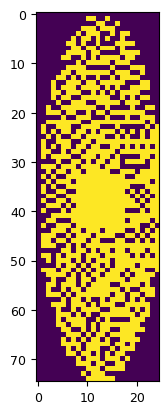

In [9]:
#loss_fn = 'perceptual'
loss_fn = 'mse'
# defining mask
R=2
calib_size=10
in_seed = 0
imSize = img_gt_sc_all[:,:,:,0].shape
mask = poissonDiscSigpy(imSize,R, in_seed,calib_size)

mps = np.ones(ksp_fs_sc_all[:,:,:,:,0].shape,dtype=complex) #single coil

fig=plt.figure()
plt.imshow((abs(mask)))

1/np.mean(abs(mask)) #true R value

1.9389865563598758

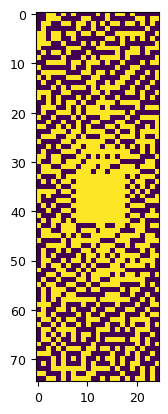

In [10]:
# imSizeBig = [91,64,41]
# #loss_fn = 'perceptual'
# loss_fn = 'mse'
# # defining mask
# R=2.74
# calib_size=10
# in_seed = 5
# imSize = img_gt_sc_all[:,:,:,0].shape

# mask = poissonDiscSigpy(imSizeBig,R, in_seed,calib_size)
# mask = mask[8:83,8:33]
# mps = np.ones(ksp_fs_sc_all[:,:,:,:,0].shape,dtype=complex) #single coil

# fig=plt.figure()
# plt.imshow((abs(mask)))

# 1/np.mean(abs(mask)) #true R value

In [11]:
mask.shape

(75, 25)

In [12]:
91-8

83

1.9736842105263157

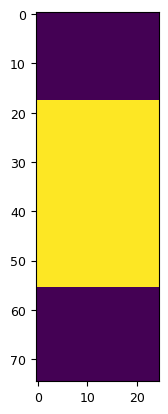

In [13]:
mask_sq = np.zeros(mask.shape)

crop_no_pe1 = 19
crop_no_pe2 = 1
#mask_sq[crop_no_pe1-1:-crop_no_pe1,crop_no_pe2-1:-crop_no_pe2]=1
mask_sq[crop_no_pe1-1:-crop_no_pe1,:]=1

fig=plt.figure()
plt.imshow((abs(mask_sq)))

1/np.mean(abs(mask_sq)) #true R value

1.934984520123839


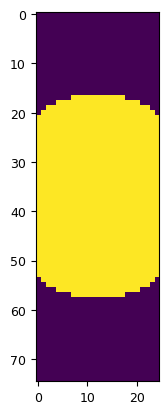

In [14]:
x_c = 37
y_c = 12

r=20.8

mask_circ = np.zeros(mask.shape)
for j in range(mask.shape[0]):
    for k in range(mask.shape[1]):
        if r > np.sqrt((j-x_c)**2+(k-y_c)**2):
            mask_circ[j,k]=1

fig=plt.figure()
plt.imshow((abs(mask_circ)))

print(1/np.mean(abs(mask_circ))) #true R value

mask_sq= mask_circ

In [15]:
#noise_dB = np.arange(50,100,2)
#n_ex_cs = 10
#n_ex_test=100

#noise_dB = np.array([50,60,70,80,90])
#noise_dB = np.array([60,90])
noise_dB = np.arange(50,95,2.5)
snr_val = 100.0*np.power(10.0,(noise_dB-80.0)/20.0)
#n_ex_cs = 1
n_ex_cs = 5

#n_ex_cs = 3
n_ex_test = 30

In [16]:
noise_dB

array([50. , 52.5, 55. , 57.5, 60. , 62.5, 65. , 67.5, 70. , 72.5, 75. ,
       77.5, 80. , 82.5, 85. , 87.5, 90. , 92.5])

In [17]:
noise_dB_zero = noise_dB - 40

In [18]:
snr_val

array([  3.16227766,   4.21696503,   5.62341325,   7.49894209,
        10.        ,  13.33521432,  17.7827941 ,  23.71373706,
        31.6227766 ,  42.16965034,  56.23413252,  74.98942093,
       100.        , 133.35214322, 177.827941  , 237.13737057,
       316.22776602, 421.69650343])

In [19]:
lamda_opt_vals = np.zeros((noise_dB.size,n_ex_cs))
iter_opt_vals = np.zeros((noise_dB.size,n_ex_cs))
lamda_opt_vals_sq = np.zeros((noise_dB.size,n_ex_cs))
iter_opt_vals_sq = np.zeros((noise_dB.size,n_ex_cs))

In [ ]:
for j, noise_val in enumerate(noise_dB):
    for k in range(n_ex_cs):
        kspTestScaled = ksp_fs_sc_all[:,:,:,:,k]
        volumeGTscaled = img_gt_sc_all[:,:,:,k]
        
        kspInput = awgn(kspTestScaled,noise_val+3,L=1)
        uskspace = applyMask(kspInput,mask)

        lamda_opt_vals[j,k] = find_lamda_mask(uskspace, volumeGTscaled, mps,calib_size, show_plot=False)
        iter_opt_vals[j,k] = find_iter_mask(uskspace,volumeGTscaled, lamda_opt_vals[j,k], mps, show_plot=False)

lamda_opt = lamda_opt_vals.mean(axis=1)
iter_opt = iter_opt_vals.mean(axis=1)

/home/david/repos/lowfieldrecon/LowFieldReconPrivate/metrics.py:39: RuntimeWarning: invalid value encountered in divide
  im2_mag_uint8 = (I_pred * 255 / np.max(I_pred)).astype('uint8')
/home/david/repos/lowfieldrecon/LowFieldReconPrivate/metrics.py:39: RuntimeWarning: invalid value encountered in cast
  im2_mag_uint8 = (I_pred * 255 / np.max(I_pred)).astype('uint8')


In [ ]:
# for j, noise_val in enumerate(noise_dB):
#     for k in range(n_ex_cs):
#         kspTestScaled = ksp_fs_sc_all[:,:,:,:,k]
#         volumeGTscaled = img_gt_sc_all[:,:,:,k]
        
#         kspInput = awgn(kspTestScaled,noise_val,L=1)
#         uskspace = applyMask(kspInput,mask_sq)

#         lamda_opt_vals_sq[j,k] = find_lamda_mask(uskspace, volumeGTscaled, mps,calib_size, show_plot=False, iter=1)
#         iter_opt_vals_sq[j,k] = find_iter_mask(uskspace,volumeGTscaled, lamda_opt_vals[j,k], mps, show_plot=False)

# lamda_opt_sq = lamda_opt_vals_sq.mean(axis=1)
# iter_opt_sq = iter_opt_vals_sq.mean(axis=1)

In [ ]:
nrmse_cs_vals = np.zeros((noise_dB.size,n_ex_test))
nrmse_ifft_vals = np.zeros((noise_dB.size,n_ex_test))
nrmse_3dB_vals = np.zeros((noise_dB.size,n_ex_test))
nrmse_ifft_sq_vals = np.zeros((noise_dB.size,n_ex_test))

ssim_cs_vals = np.zeros((noise_dB.size,n_ex_test))
ssim_ifft_vals = np.zeros((noise_dB.size,n_ex_test))
ssim_3dB_vals = np.zeros((noise_dB.size,n_ex_test))
ssim_ifft_sq_vals = np.zeros((noise_dB.size,n_ex_test))

In [ ]:
for j, noise_val in enumerate(noise_dB):
    for k in range(n_ex_test):
        kspTestScaled = ksp_fs_sc_all[:,:,:,:,k+n_ex_cs]
        volumeGTscaled = img_gt_sc_all[:,:,:,k+n_ex_cs]


        #PD
        
        kspInput = awgn(kspTestScaled,noise_val+3,L=1)
        uskspace = applyMask(kspInput,mask)

    
        volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
        volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

        volcsrecon = ulfl1recon(uskspace,mask,lamda_opt[j],iter_opt[j],mps)

        # sq
        uskspace_sq = applyMask(kspInput,mask_sq)

        volifftsqrecon_mc = sp.ifft(uskspace_sq,axes=[1,2,3])
        volifftsqrecon = coil_combine(volifftsqrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

        #volcssqrecon = ulfl1recon(uskspace_sq,mask,lamda_opt_sq[j],iter_opt_sq[j],mps)
        kspInput3dB = awgn(kspTestScaled,noise_val,L=1)
        vol3dBrecon_mc = sp.ifft(kspInput3dB,axes=[1,2,3])
        vol3dBrecon = coil_combine(vol3dBrecon_mc,mps)
        
        mask_metrics = np.ma.getmask(np.ma.masked_less(abs(volumeGTscaled),0.05)) # a mask in the image domain for calculating image metrics (not for masking kspace)

        volumeGTscaled[mask_metrics]=0
        volcsrecon[mask_metrics]=0
        volifftrecon[mask_metrics]=0
        vol3dBrecon[mask_metrics]=0
        volifftsqrecon[mask_metrics]=0


        nrmse_cs_vals[j,k] = nrmse(np.abs(volcsrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        nrmse_ifft_vals[j,k] = nrmse(np.abs(volifftrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        nrmse_3dB_vals[j,k] = nrmse(np.abs(vol3dBrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        nrmse_ifft_sq_vals[j,k] = nrmse(np.abs(volifftsqrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))

        ssim_cs_vals[j,k] = ssim(np.abs(volcsrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        ssim_ifft_vals[j,k] = ssim(np.abs(volifftrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        ssim_3dB_vals[j,k] = ssim(np.abs(vol3dBrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        ssim_ifft_sq_vals[j,k] = ssim(np.abs(volifftsqrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))



In [ ]:
nrmse_cs = nrmse_cs_vals.mean(axis=1)
nrmse_ifft = nrmse_ifft_vals.mean(axis=1)
nrmse_3dB = nrmse_3dB_vals.mean(axis=1)
nrmse_ifft_sq = nrmse_ifft_sq_vals.mean(axis=1)

nrmse_cs_sd = nrmse_cs_vals.std(axis=1)
nrmse_ifft_sd = nrmse_ifft_vals.std(axis=1)
nrmse_3dB_sd = nrmse_3dB_vals.std(axis=1)
nrmse_ifft_sq_sd = nrmse_ifft_sq_vals.std(axis=1)

ssim_cs = ssim_cs_vals.mean(axis=1)
ssim_ifft = ssim_ifft_vals.mean(axis=1)
ssim_3dB = ssim_3dB_vals.mean(axis=1)
ssim_ifft_sq = ssim_ifft_sq_vals.mean(axis=1)

ssim_cs_sd = ssim_cs_vals.std(axis=1)
ssim_ifft_sd = ssim_ifft_vals.std(axis=1)
ssim_3dB_sd = ssim_3dB_vals.std(axis=1)
ssim_ifft_sq_sd = ssim_ifft_sq_vals.std(axis=1)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(7,3)
fig.subplots_adjust(wspace=0.3)

#line1 = ax1.plot(noise_dB_zero,nrmse_ifft, '-')
line3 = ax1.plot(noise_dB_zero,nrmse_3dB, '-')
line4 = ax1.plot(noise_dB_zero,nrmse_ifft_sq, '-')
line2 = ax1.plot(noise_dB_zero,nrmse_cs, '-')
#ax1.set(title='Comparison of Reconstruction Methods, R='+str(R),
ax1.set(ylabel='NRMSE',
xlabel='Input SNR (dB)')
#ax1.set_xscale('log')
#ax1.set_xscale('log')
ax1.legend([ 'Fully-Samped', 'IFFT Sq R=2, NA=2', 'CS PD R=2, NA=2'])
#ax1.legend([line1, line2, line3], ['label1', 'label2', 'label3'])
#fill1 = ax1.fill_between(noise_dB_zero,nrmse_ifft-nrmse_ifft_sd,nrmse_ifft+nrmse_ifft_sd,alpha=0.25)
fill3 = ax1.fill_between(noise_dB_zero,nrmse_3dB-nrmse_3dB_sd,nrmse_3dB+nrmse_3dB_sd,alpha=0.25)
fill4 = ax1.fill_between(noise_dB_zero,nrmse_ifft_sq-nrmse_ifft_sq_sd,nrmse_ifft_sq+nrmse_ifft_sq_sd,alpha=0.25)
fill2 = ax1.fill_between(noise_dB_zero,nrmse_cs-nrmse_cs_sd,nrmse_cs+nrmse_cs_sd,alpha=0.25)

step=10
#ax1.set_xticks(np.arange(noise_dB_zero[0],noise_dB_zero[-1]+step,step))
ax1.set_yticks([0,0.05,0.1])
ax1.set_xlim([10,50])
ax1.set_ylim([0,0.1])



#line1 = ax2.plot(noise_dB_zero,ssim_ifft, '-')
line3 = ax2.plot(noise_dB_zero,ssim_3dB, '-')
line4 = ax2.plot(noise_dB_zero,ssim_ifft_sq, '-')
line2 = ax2.plot(noise_dB_zero,ssim_cs, '-')
#ax2.set(title='Comparison of Reconstruction Methods, R='+str(R),
ax2.set(ylabel='SSIM',
xlabel='Input SNR (dB)')
#ax1.set_xscale('log')
ax2.legend([ 'Fully-Samped', 'IFFT Sq R=2, NA=2', 'CS PD R=2, NA=2'])
#ax1.legend([line1, line2, line3], ['label1', 'label2', 'label3'])
ax2.set_ylim(0.65,1.01)
ax2.set_xlim(10,50)

#fill1 = ax2.fill_between(noise_dB_zero,ssim_ifft-ssim_ifft_sd,ssim_ifft+ssim_ifft_sd,alpha=0.25)

fill3 = ax2.fill_between(noise_dB_zero,ssim_3dB-ssim_3dB_sd,ssim_3dB+ssim_3dB_sd,alpha=0.25)
fill4 = ax2.fill_between(noise_dB_zero,ssim_ifft_sq-ssim_ifft_sq_sd,ssim_ifft_sq+ssim_ifft_sq_sd,alpha=0.25)
fill2 = ax2.fill_between(noise_dB_zero,ssim_cs-ssim_cs_sd,ssim_cs+ssim_cs_sd,alpha=0.25)

step=10
#ax2.set_xticks(np.arange(noise_dB[0],noise_dB[-1]+step,step))
#ax2.set_yticks([0.8,0.9,1])

plt.show()

fig.savefig('export_figs/fastmri_noise_curves.pdf',bbox_inches='tight',dpi=300)

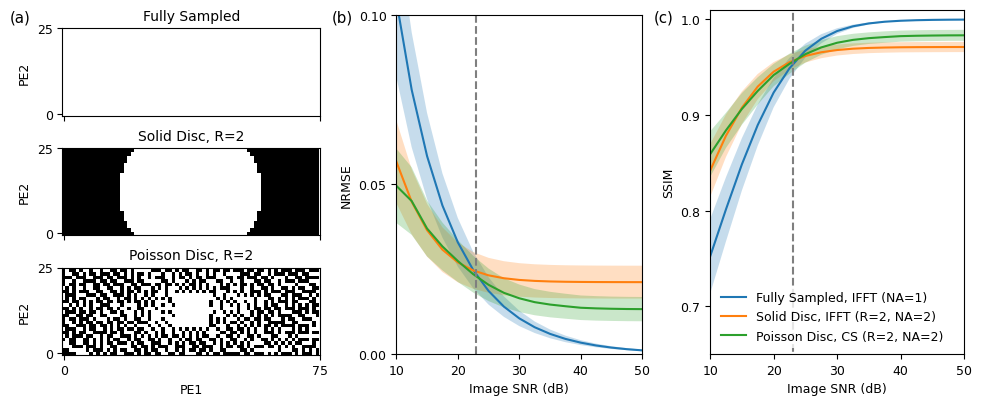

In [40]:
figsamp = plt.figure(figsize=(1.3*18.8/2.54,10/2.54),layout='compressed')
subfigs = figsamp.subfigures(1,3,wspace=0.01)

#subfigs[0] = fig
#subfigs[1] = fig
subfigs[0].suptitle('(a)',x=0.02,y=0.99)
axsLeft = subfigs[0].subplots(3,1,sharex=True)
mask1 = axsLeft[0].imshow(np.ones(mask.shape).T,clim=(0,1),origin='lower',cmap='gray')
mask2 = axsLeft[1].imshow(np.abs(mask_circ.T),clim=(0,1),origin='lower',cmap='gray')
mask3 = axsLeft[2].imshow(np.abs(mask.T),clim=(0,1),origin='lower',cmap='gray')
axsLeft[0].set_ylabel('PE2')
axsLeft[1].set_ylabel('PE2')
axsLeft[2].set_ylabel('PE2')
axsLeft[2].set_xlabel('PE1')
#axsLeft[1] = ax2
mask1.set_clim(0,1)

axsLeft[0].set_title('Fully Sampled',fontsize=10)
axsLeft[1].set_title('Solid Disc, R=2',fontsize=10)
axsLeft[2].set_title('Poisson Disc, R=2',fontsize=10)

for ax in axsLeft:
    ax.set_xticks([0,75])
    ax.set_yticks([0,25])


subfigs[1].suptitle('(b)',x=0.02,y=0.99)

axsCentre = subfigs[1].subplots(1,1)

#line1 = axsCentre.plot(noise_dB_zero,nrmse_ifft, '-')
line3 = axsCentre.plot(noise_dB_zero,nrmse_3dB, '-')
line4 = axsCentre.plot(noise_dB_zero,nrmse_ifft_sq, '-')
line2 = axsCentre.plot(noise_dB_zero,nrmse_cs, '-')
#axsCentre.set(title='Comparison of Reconstruction Methods, R='+str(R),
axsCentre.set(ylabel='NRMSE',
xlabel='Image SNR (dB)')

fill3 = axsCentre.fill_between(noise_dB_zero,nrmse_3dB-nrmse_3dB_sd,nrmse_3dB+nrmse_3dB_sd,alpha=0.25)
fill4 = axsCentre.fill_between(noise_dB_zero,nrmse_ifft_sq-nrmse_ifft_sq_sd,nrmse_ifft_sq+nrmse_ifft_sq_sd,alpha=0.25)
fill2 = axsCentre.fill_between(noise_dB_zero,nrmse_cs-nrmse_cs_sd,nrmse_cs+nrmse_cs_sd,alpha=0.25)

step=10
#axsCentre.set_xticks(np.arange(noise_dB_zero[0],noise_dB_zero[-1]+step,step))
axsCentre.set_yticks([0,0.05,0.1])
axsCentre.set_xlim([10,50])
axsCentre.set_ylim([0,0.1])
#axsCentre.set_aspect(400)
axsCentre.vlines(23,0,2,color='tab:gray',linestyle='--')

subfigs[2].suptitle('(c)',x=0.02,y=0.99)

axsRight = subfigs[2].subplots(1,1)

#line1 = axsRight.plot(noise_dB_zero,ssim_ifft, '-')
line3 = axsRight.plot(noise_dB_zero,ssim_3dB, '-')
line4 = axsRight.plot(noise_dB_zero,ssim_ifft_sq, '-')
line2 = axsRight.plot(noise_dB_zero,ssim_cs, '-')
#axsRight.set(title='Comparison of Reconstruction Methods, R='+str(R),
axsRight.set(ylabel='SSIM',
xlabel='Image SNR (dB)')
#axsCentre.set_xscale('log')
leg = axsRight.legend([ 'Fully Sampled, IFFT (NA=1)', 'Solid Disc, IFFT (R=2, NA=2)', 'Poisson Disc, CS (R=2, NA=2)'])
leg.get_frame().set_linewidth(0.0)
#axsCentre.legend([line1, line2, line3], ['label1', 'label2', 'label3'])
axsRight.set_ylim(0.65,1.01)
axsRight.set_xlim(10,50)
axsRight.set_yticks([0.7,0.8,0.9,1.0])
axsRight.vlines(23,0,2,color='tab:gray',linestyle='--')

#fill1 = axsRight.fill_between(noise_dB_zero,ssim_ifft-ssim_ifft_sd,ssim_ifft+ssim_ifft_sd,alpha=0.25)

fill3 = axsRight.fill_between(noise_dB_zero,ssim_3dB-ssim_3dB_sd,ssim_3dB+ssim_3dB_sd,alpha=0.25)
fill4 = axsRight.fill_between(noise_dB_zero,ssim_ifft_sq-ssim_ifft_sq_sd,ssim_ifft_sq+ssim_ifft_sq_sd,alpha=0.25)
fill2 = axsRight.fill_between(noise_dB_zero,ssim_cs-ssim_cs_sd,ssim_cs+ssim_cs_sd,alpha=0.25)

#figsamp.savefig('export_figs/fastmri_sampling_snr.pdf',bbox_inches='tight',dpi=300)

## Low SNR

In [ ]:
test_no = 125
kspTestScaled = ksp_fs_sc_all[:,:,:,:,test_no]
volumeGTscaled = img_gt_sc_all[:,:,:,test_no]
mask_metrics = np.ma.getmask(np.ma.masked_less(abs(volumeGTscaled),0.05)) # a mask in the image domain for calculating image metrics (not for masking kspace)

l = 2
noise_val = noise_dB[l]
lamda_val = lamda_opt[l]
iter_val = iter_opt[l]

print(noise_val-40)

In [ ]:
kspInput = awgn(kspTestScaled,noise_val,L=1)
uskspace = applyMask(kspInput,mask)


volcsrecon = ulfl1recon(uskspace,mask,lamda_val,iter_val,mps)
    
volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

# sq
uskspace_sq = applyMask(kspInput,mask_sq)

volifftsqrecon_mc = sp.ifft(uskspace_sq,axes=[1,2,3])
volifftsqrecon = coil_combine(volifftsqrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

kspInput3dB = awgn(kspTestScaled,noise_val-3,L=1)
vol3dBrecon_mc = sp.ifft(kspInput3dB,axes=[1,2,3])
vol3dBrecon = coil_combine(vol3dBrecon_mc,mps)

### Background Masked

In [ ]:
volumeGTscaledmasked = np.copy(volumeGTscaled[:,:,1:])
volumeGTscaledmasked[mask_metrics[:,:,1:]]=0
vol1 = np.copy(volifftrecon[:,:,1:])#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol1[mask_metrics[:,:,1:]]=0
vol1title = 'Zero-filled IFFT\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol2 = np.copy(volcsrecon[:,:,1:])
vol2[mask_metrics[:,:,1:]]=0
vol2title = 'Compressed Sensing\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol3 = np.copy(volifftsqrecon[:,:,1:])
vol3[mask_metrics[:,:,1:]]=0
vol3title = 'IFFT SQ'+str(noise_val)+', R = '+str(R)
vol4 = np.copy(vol3dBrecon[:,:,1:])
vol4[mask_metrics[:,:,1:]]=0
vol4title = 'IFFT 3dB'+str(noise_val)+', R = '+str(R)

vol1_low = vol1
vol2_low = vol2
vol3_low = vol3
vol4_low = vol4

slc=10
fig_comp = display_fns.compareFourPlot(volumeGTscaledmasked,vol1,vol1title,vol2,vol2title,vol3,vol3title,vol4,vol4title,slc, scale_err=3)

fig_comp.savefig('export_figs/fastmri_imgs_masked_snr'+str(noise_val)+'dB.pdf',bbox_inches='tight',dpi=300)

In [ ]:
noise_val=60
kspInput = awgn(kspTestScaled,noise_val,L=1)

# calculating SNR of input kspace (fully sampled)
fs_recon_awgn = sp.ifft(kspInput,axes=[1,2,3])
im_slice = fs_recon_awgn[0,:,32,:]
fig=plt.figure()
plt.imshow((abs(im_slice)))
noise = np.std(np.abs(im_slice[0:8,10:20]))
signal = np.mean(np.abs(im_slice[20:40,0:10]))
snr=signal/noise
print('SNR')
snr

In [ ]:
noise = np.std(np.abs(fs_recon_awgn[0,:,0:8,18:24]))
signal = np.mean(np.abs(fs_recon_awgn[0,28:45,30:40,10:18]))
snr=signal/noise
print(noise)
print(signal)
print(snr)

In [ ]:
100.0*np.power(10.0,(noise_val-80.0)/20.0)

In [ ]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'
fig = px.imshow(np.abs(fs_recon_awgn[0,:,:,:]),animation_frame=0, color_continuous_scale='viridis', labels=dict(animation_frame="Slice"),template='plotly_dark')
fig

In [ ]:
fs_recon = sp.ifft(kspTestScaled,axes=[1,2,3])

In [ ]:
noise_val=60
vol_shepp=sp.shepp_logan(imSize)
#vol_shepp=sp.shepp_logan([128,128,128])
kshepp = sp.fft(vol_shepp,axes=[0,1,2])

scale_factor = np.percentile(abs(vol_shepp),95) 
kshepp = kshepp/scale_factor

kshepp_awgn = awgn(kshepp,noise_val,L=1)
vol_shepp_awgn = sp.ifft(kshepp_awgn,axes=[0,1,2])

im_slice = vol_shepp_awgn[:,32,:]
fig=plt.figure()
plt.imshow((abs(im_slice)))

noise = np.std(np.abs(im_slice[0:8,0:7]))
signal = np.mean(np.abs(im_slice[10:20,10:15]))
snr=signal/noise
print('SNR')
snr

In [ ]:
noise_val=80
kspInput = awgn(kspTestScaled,noise_val,L=1)

# calculating SNR of input kspace (fully sampled)
fs_recon = sp.ifft(kspInput,axes=[1,2,3])
im_slice = fs_recon[0,:,32,:]
fig=plt.figure()
plt.imshow((abs(im_slice)))
noise = np.std(np.abs(im_slice[0:8,10:20]))
signal = np.mean(np.abs(im_slice[20:40,0:10]))
snr=signal/noise
print('SNR')
snr

In [ ]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'
#import plotly
#plotly.offline.init_notebook_mode(connected=True) 
#plotly.io.renderers.default='notebook'
fig = px.imshow(np.abs(vol_shepp_awgn),animation_frame=0, color_continuous_scale='viridis', labels=dict(animation_frame="Slice"),template='plotly_dark')
#fig.update_layout(title='Channel Raw')
fig

### Background Unmasked

In [ ]:
volumeGTscaledmasked = np.copy(volumeGTscaled[:,:,1:])
#volumeGTscaledmasked[mask_metrics[:,:,1:]]=0
vol1 = np.copy(volifftrecon[:,:,1:])#np.ma.masked_array(volifftrecon, mask = mask_metrics)
#vol1[mask_metrics[:,:,1:]]=0
vol1title = 'Zero-filled IFFT'
vol2 = np.copy(volcsrecon[:,:,1:])
#vol2[mask_metrics[:,:,1:]]=0
vol2title = 'Compressed Sensing'
vol3 = np.copy(volamaprecon[:,:,1:])
#vol3[mask_metrics[:,:,1:]]=0
vol3title = 'AUTOMAP'
vol4 = np.copy(volunrollrecon[:,:,1:])
#vol4[mask_metrics[:,:,1:]]=0
vol4title = 'Unrolled'

slc=10
fig_comp = display_fns.compareFourPlot(volumeGTscaledmasked,vol1,vol1title,vol2,vol2title,vol3,vol3title,vol4,vol4title,slc, scale_err=3)

fig_comp.savefig('export_figs/fastmri_imgs_snr'+str(noise_val)+'dB.pdf',bbox_inches='tight',dpi=300)

## High SNR

In [ ]:
#test_no=125
kspTestScaled = ksp_fs_sc_all[:,:,:,:,test_no]
volumeGTscaled = img_gt_sc_all[:,:,:,test_no]
mask_metrics = np.ma.getmask(np.ma.masked_less(abs(volumeGTscaled),0.05)) # a mask in the image domain for calculating image metrics (not for masking kspace)

l=-1
noise_val = noise_dB[l]
lamda_val = lamda_opt[l]
iter_val = iter_opt[l]

In [ ]:
noise_val

In [ ]:
kspInput = awgn(kspTestScaled,noise_val,L=1)
uskspace = applyMask(kspInput,mask)


volcsrecon = ulfl1recon(uskspace,mask,lamda_val,iter_val,mps)
    
volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

amap_scale = 1
unroll_scale = 1#0.25#1/8
volunrollrecon = unrolling_fns.unrollingRecon(uskspace*unroll_scale,mask,unroll_model_pth)/unroll_scale
#volunrollrecon = np.roll(volunrollrecon,(-1,-1),axis=(0,2))
volamaprecon, volamaprecon_mc = automap_fns.automapRecon(uskspace*amap_scale,mps,model_real_dir,model_imag_dir)
volamaprecon = volamaprecon/amap_scale
volamaprecon_mc = volamaprecon_mc/amap_scale

In [ ]:
# calculating SNR of input kspace (fully sampled)
fs_recon = sp.ifft(kspInput,axes=[1,2,3])
im_slice = fs_recon[0,:,32,:]
fig=plt.figure()
plt.imshow((abs(im_slice)))
noise = np.std(np.abs(im_slice[0:8,10:20]))
signal = np.mean(np.abs(im_slice[20:40,0:10]))
snr=signal/noise
print('SNR')
snr

### Background Masked

In [ ]:
volumeGTscaledmasked = np.copy(volumeGTscaled[:,:,1:])
volumeGTscaledmasked[mask_metrics[:,:,1:]]=0
vol1 = np.copy(volifftrecon[:,:,1:])#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol1[mask_metrics[:,:,1:]]=0
vol1title = 'Zero-filled IFFT\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol2 = np.copy(volcsrecon[:,:,1:])
vol2[mask_metrics[:,:,1:]]=0
vol2title = 'Compressed Sensing\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol3 = np.copy(volamaprecon[:,:,1:])
vol3[mask_metrics[:,:,1:]]=0
vol3title = 'AUTOMAP\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol4 = np.copy(volunrollrecon[:,:,1:])
vol4[mask_metrics[:,:,1:]]=0
vol4title = 'Unrolling\nInp. SNR='+str(noise_val)+', R = '+str(R)

vol1_high = vol1
vol2_high = vol2
vol3_high = vol3
vol4_high = vol4

slc=10
fig_comp = display_fns.compareFourPlot(volumeGTscaledmasked,vol1,vol1title,vol2,vol2title,vol3,vol3title,vol4,vol4title,slc, scale_err=3)

fig_comp.savefig('export_figs/fastmri_imgs_masked_snr'+str(noise_val)+'dB.pdf',bbox_inches='tight',dpi=300)

In [ ]:
volumeGTscaledmasked = np.copy(volumeGTscaled[:,:,1:])
volumeGTscaledmasked[mask_metrics[:,:,1:]]=0
vol1 = np.copy(volifftrecon[:,:,1:])#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol1[mask_metrics[:,:,1:]]=0
vol1title = 'Zero-filled IFFT\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol2 = np.copy(volcsrecon[:,:,1:])
vol2[mask_metrics[:,:,1:]]=0
vol2title = 'Compressed Sensing\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol3 = np.copy(volamaprecon[:,:,1:])
vol3[mask_metrics[:,:,1:]]=0
vol3title = 'AUTOMAP\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol4 = np.copy(volunrollrecon[:,:,1:])
vol4[mask_metrics[:,:,1:]]=0
vol4title = 'Unrolling\nInp. SNR='+str(noise_val)+', R = '+str(R)

slc=10
fig_comp = display_fns.compareFourPlot(volumeGTscaledmasked,vol1,vol1title,vol2,vol2title,vol3,vol3title,vol4,vol4title,slc, scale_err=3)

fig_comp.savefig('export_figs/fastmri_imgs_masked_snr'+str(noise_val)+'dB.pdf',bbox_inches='tight',dpi=300)

### Background Unmasked

In [ ]:
volumeGTscaledmasked = np.copy(volumeGTscaled[:,:,1:])
#volumeGTscaledmasked[mask_metrics[:,:,1:]]=0
vol1 = np.copy(volifftrecon[:,:,1:])#np.ma.masked_array(volifftrecon, mask = mask_metrics)
#vol1[mask_metrics[:,:,1:]]=0
vol1title = 'Zero-filled IFFT'
vol2 = np.copy(volcsrecon[:,:,1:])
#vol2[mask_metrics[:,:,1:]]=0
vol2title = 'Compressed Sensing'
vol3 = np.copy(volamaprecon[:,:,1:])
#vol3[mask_metrics[:,:,1:]]=0
vol3title = 'AUTOMAP'
vol4 = np.copy(volunrollrecon[:,:,1:])
#vol4[mask_metrics[:,:,1:]]=0
vol4title = 'Unrolled'

slc=10
fig_comp = display_fns.compareFourPlot(volumeGTscaledmasked,vol1,vol1title,vol2,vol2title,vol3,vol3title,vol4,vol4title,slc, scale_err=3)

fig_comp.savefig('export_figs/fastmri_imgs_snr'+str(noise_val)+'dB.pdf',bbox_inches='tight',dpi=300)

## Comparing images

In [ ]:
vol1title = 'Zero-filled IFFT'
vol2 = np.copy(volcsrecon[:,:,1:])
#vol2[mask_metrics[:,:,1:]]=0
vol2title = 'Comp. Sensing'
vol3 = np.copy(volamaprecon[:,:,1:])
#vol3[mask_metrics[:,:,1:]]=0
vol3title = 'AUTOMAP'
vol4 = np.copy(volunrollrecon[:,:,1:])
#vol4[mask_metrics[:,:,1:]]=0
vol4title = 'Unrolled'


GT = volumeGTscaledmasked
#    GT = np.swapaxes(GT,0,1)
#    vol1 = np.swapaxes(vol1,0,1)
#    vol2 = np.swapaxes(vol2,0,1)
#    vol3 = np.swapaxes(vol3,0,1)
#    vol4 = np.swapaxes(vol4,0,1)

# RO 64, 2.5 mm
# PE1 75, 3.5mm
# PE2 15, 8 mm
asp_ratio = (GT.shape[1]*3.5)/(GT.shape[0]*2.5)

fig, axs = plt.subplots(2, 5,figsize = (11,5))

max_GT = np.amax(np.abs(GT[:,:,slc]))

im = axs[0, 0].imshow(np.abs(GT[:,:,slc].T), cmap= 'gray', vmin = 0, vmax = 1.05*max_GT)
axs[0, 0].set_title('Reference',fontweight='bold')
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[0, 0].set_aspect(asp_ratio)
l, b, w, h = axs[0,0].get_position().bounds
axs[0, 0].set_position([l-0.03,b,w,h])
im.set_clim(0, (1.05*max_GT))

im = axs[0, 1].imshow(np.abs(vol1_high[:,:,slc].T), cmap = 'gray', vmin = 0,vmax = 1.05*max_GT)
axs[0, 1].set_title(vol1title,fontweight='bold')
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT))
axs[0, 1].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol1_high[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol1_high[:,:,:]),np.abs(GT[:,:,:])),3)))

axs[0, 1].set_ylabel('SNR '+str(noise_dB[-1])+' dB',fontsize=11, fontweight='bold')

im = axs[1, 1].imshow(np.abs(vol1_low[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
#axs[1, 1].set_title(vol1title + ' Diff')
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
axs[1, 1].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT))
axs[1, 1].set_xlabel('SSIM ='+str(round(ssim(np.abs(vol1_low[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE ='+str(round(nrmse(np.abs(vol1_low[:,:,:]),np.abs(GT[:,:,:])),3)))
axs[1, 1].set_ylabel('SNR '+str(noise_dB[0])+' dB',fontsize=11, fontweight='bold')


im = axs[0, 2].imshow(np.abs(vol2_high[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
axs[0, 2].set_title(vol2title,fontweight='bold')
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])
axs[0, 2].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT))
axs[0, 2].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol2_high[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol2_high[:,:,:]),np.abs(GT[:,:,:])),3)))

im = axs[1, 2].imshow(np.abs(vol2_low[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
#axs[1, 2].set_title(vol2title + ' Diff')
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])
axs[1, 2].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT))
axs[1, 2].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol2_low[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol2_low[:,:,:]),np.abs(GT[:,:,:])),3)))

im = axs[0, 3].imshow(np.abs(vol3_high[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
axs[0, 3].set_title(vol3title,fontweight='bold')
axs[0, 3].set_xticks([])
axs[0, 3].set_yticks([])
axs[0, 3].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT))
axs[0, 3].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol3_high[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol3_high[:,:,:]),np.abs(GT[:,:,:])),3)))

im = axs[1, 3].imshow(np.abs(vol3_low[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
#axs[1, 3].set_title(vol3title + ' Diff')
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])
axs[1, 3].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT))
axs[1, 3].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol3_low[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol3_low[:,:,:]),np.abs(GT[:,:,:])),3)))

im = axs[0, 4].imshow(np.abs(vol4_high[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
axs[0, 4].set_title(vol4title,fontweight='bold')
axs[0, 4].set_xticks([])
axs[0, 4].set_yticks([])
axs[0, 4].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT))
axs[0, 4].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol4_high[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol4_high[:,:,:]),np.abs(GT[:,:,:])),3)))

im = axs[1, 4].imshow(np.abs(vol4_low[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT)
#axs[1, 4].set_title(vol4title + ' Diff')
axs[1, 4].set_xticks([])
axs[1, 4].set_yticks([])
axs[1, 4].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT))
axs[1, 4].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol4_low[:,:,:]),np.abs(GT[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol4_low[:,:,:]),np.abs(GT[:,:,:])),3)))


axs[1, 0].axis('off')

#fig.tight_layout()
#fig.subplots_adjust(right=0.8)
#fig.subplots_adjust(hspace=-0.2)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
#fig.colorbar(im, cax=cbar_ax)

plt.show()

fig.savefig('export_figs/fastmri_imgs_compare_snr.pdf',bbox_inches='tight',dpi=300)

In [ ]:
kplot = (np.abs(uskspace[0,:,:,:]))

In [ ]:
kplot.shape

In [ ]:
fig, ax = plt.subplots()
ax = plt.imshow(np.squeeze(np.transpose(np.log(np.abs(kplot[:,32,:])))),origin='lower')
plt.ylabel('Phase Encode 2')
plt.xlabel('Phase Encode 1')
plt.xticks([0,75])
plt.yticks([0,25])
plt.show()

fig.savefig('export_figs/kspace_masked.pdf',bbox_inches='tight',dpi=300)

In [ ]:
kplot = kplot[:,30:33,:]

In [ ]:


fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')

x, y, z = kplot[:,:,:].nonzero()

colors = np.zeros(np.size(x))
for k in range(np.size(x)):
    colors[k]=kplot[x[k],y[k],z[k]]

colors=kplot[x,y,z]
colors = np.log(colors[colors != 0])

ax.scatter(x,y,z,c=colors,marker="s",s=18,alpha=1)
#ax.elev=0
#ax.azim=90
#ax.set_box_aspect(None, zoom=2)
plt.show()


In [ ]:
colors.shape

In [ ]:
x.shape

## Scaling data

In [ ]:
# stock standard recon to get an appropriate scaling factor for the ksp data
img_rss = np.sum(np.abs(sp.ifft(kspGT, axes=(-1, -2, -3)))**2, axis=0)**0.5
volumeGTrss = img_rss

pl.ImagePlot(img_rss, x=1,y=0,title='Root-sum-of-squares Fully-sampled')

# scaling all numbers to sensible values from the beginning
scale_factor = np.percentile(abs(volumeGTrss),95) 
kspGTscaled = kspGT/scale_factor

yshift=0
#yshift = -2
kspGTscaled = np.roll(kspGTscaled,(0,yshift,0),axis=(1,2,3))

if kspGTscaled.shape[0] == 1:
    mps = np.ones(kspGTscaled.shape,dtype=complex)
else:
    mps = mr.app.EspiritCalib(kspGTscaled, calib_width=20, kernel_width=6, show_pbar=True).run()
#mps = np.ones(kspGTscaled.shape)
img_fs = sp.ifft(kspGTscaled, axes=(-1, -2, -3))
volumeGTscaled = coil_combine(img_fs,mps)

### Calculating Image Masks

In [ ]:
mask_metrics = np.ma.getmask(np.ma.masked_less(abs(volumeGTscaled),0.15)) # a mask in the image domain for calculating image metrics (not for masking kspace)

volumeGTscaledmasked = np.copy(volumeGTscaled)
volumeGTscaledmasked[mask_metrics]=0

### Defining test kspace

In [ ]:
kspTestScaled = kspGTscaled

#optional recentering of k-space to correct phase map
delta_x = 0
delta_y = 0
delta_z = 0
kspTestScaled = np.roll(kspTestScaled,(delta_x,delta_y,delta_z),axis=(1,2,3)) 

## Poisson Disc Mask

In [ ]:
# defining PD mask
imSize = np.array(img_rss.shape)


in_seed = 0#randrange(100)
if R==1:
  mask = poissonDiscSigpy(imSize,R, in_seed,calib_size)  
elif R==2:
  mask = poissonDiscSigpy(imSize,R, in_seed,calib_size)
elif R==4:
  mask = poissonDiscSigpy(imSize,R+0.5, in_seed,calib_size)  
mask.shape

1/np.mean(abs(mask)) #true R value


In [ ]:
img_rss.shape

In [ ]:
# from scipy.io import savemat
# maskdic = {"mask": mask}
# savemat("mask_R4.mat",maskdic)

In [ ]:
fig=plt.figure()
plt.imshow(abs(mask),cmap='gray')
fig.savefig('export_figs/maskR2.eps')

In [ ]:
#noise_dB = np.arange(46,94,4)
#noise_dB = np.arange(30,100,10)
noise_dB = np.arange(50,100,10)
n_examples = 3

nrmse_cs_vals = np.zeros((noise_dB.size*n_examples))
nrmse_ifft_vals = np.zeros((noise_dB.size*n_examples))
nrmse_amap_vals = np.zeros((noise_dB.size*n_examples))
nrmse_unroll_vals = np.zeros((noise_dB.size*n_examples))

ssim_cs_vals = np.zeros((noise_dB.size*n_examples))
ssim_ifft_vals = np.zeros((noise_dB.size*n_examples))
ssim_amap_vals = np.zeros((noise_dB.size*n_examples))
ssim_unroll_vals = np.zeros((noise_dB.size*n_examples))

psnr_cs_vals = np.zeros((noise_dB.size*n_examples))
psnr_ifft_vals = np.zeros((noise_dB.size*n_examples))
psnr_amap_vals = np.zeros((noise_dB.size*n_examples))

In [ ]:
kspTestScaled.shape

In [ ]:
for j, noise_val in enumerate(noise_dB):

    kspInput = awgn(kspTestScaled,noise_val,L=1)
    uskspace = applyMask(kspInput,mask)

    no_masks = 1
    lamda_opt = find_lamda_mask(uskspace, volumeGTscaled, mps,calib_size, show_plot=False)
    iter_opt = find_iter_mask(uskspace,volumeGTscaled, lamda_opt, mps, show_plot=False)
    volcsrecon = ulfl1recon(uskspace,mask,lamda_opt,iter_opt,mps)
    
    volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
    volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

    
    amap_scale = 1
    unroll_scale = 1/8
    volunrollrecon = unrolling_fns.unrollingRecon(uskspace*unroll_scale,mask,unroll_model_pth)/unroll_scale
    volunrollrecon = np.roll(volunrollrecon,(1,1),axis=(0,2))
    volamaprecon, volamaprecon_mc = automap_fns.automapRecon(uskspace*amap_scale,mps,model_real_dir,model_imag_dir)
    volamaprecon = volamaprecon/amap_scale
    volamaprecon_mc = volamaprecon_mc/amap_scale
    
    volcsrecon[mask_metrics]=0
    volifftrecon[mask_metrics]=0
    volamaprecon[mask_metrics]=0
    volunrollrecon[mask_metrics]=0
    
#     nrmse_cs_vals[j] = nrmse(np.abs(volcsrecon),np.abs(volumeGTscaled))
#     nrmse_ifft_vals[j] = nrmse(np.abs(volifftrecon),np.abs(volumeGTscaled))
#     nrmse_amap_vals[j] = nrmse(np.abs(volamaprecon),np.abs(volumeGTscaled))
#     nrmse_unroll_vals[j] = nrmse(np.abs(volunrollrecon),np.abs(volumeGTscaled))

#     ssim_cs_vals[j] = ssim(np.abs(volcsrecon),np.abs(volumeGTscaled))
#     ssim_ifft_vals[j] = ssim(np.abs(volifftrecon),np.abs(volumeGTscaled))
#     ssim_amap_vals[j] = ssim(np.abs(volamaprecon),np.abs(volumeGTscaled))
#     ssim_unroll_vals[j] = ssim(np.abs(volunrollrecon),np.abs(volumeGTscaled))
    
    nrmse_cs_vals[j] = nrmse(np.abs(volcsrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
    nrmse_ifft_vals[j] = nrmse(np.abs(volifftrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
    nrmse_amap_vals[j] = nrmse(np.abs(volamaprecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
    nrmse_unroll_vals[j] = nrmse(np.abs(volunrollrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))

    ssim_cs_vals[j] = ssim(np.abs(volcsrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
    ssim_ifft_vals[j] = ssim(np.abs(volifftrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
    ssim_amap_vals[j] = ssim(np.abs(volamaprecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
    ssim_unroll_vals[j] = ssim(np.abs(volunrollrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))

    #psnr_cs_vals = psnr(abs(volumeGTscaled),abs(volcsrecon))
    #psnr_ifft_vals = psnr(abs(volumeGTscaled),abs(volifftrecon))
    #psnr_amap_vals = psnr(abs(volumeGTscaled),abs(volamaprecon))

In [ ]:
fig1, ax1 = plt.subplots()
line1 = ax1.plot(noise_dB,nrmse_ifft_vals, '-')
line2 = ax1.plot(noise_dB,nrmse_cs_vals, '-')
line3 = ax1.plot(noise_dB,nrmse_amap_vals, '-')
line4 = ax1.plot(noise_dB,nrmse_unroll_vals, '-')
ax1.set(title='Comparison of Reconstruction Methods, R='+str(R),
ylabel='NRMSE',
xlabel='Input SNR (dB)')
#ax1.set_xscale('log')
ax1.legend(['IFFT', 'CS', 'AUTOMAP', 'Unrolling'])
#ax1.legend([line1, line2, line3], ['label1', 'label2', 'label3'])
plt.ylim(0,0.085)
plt.xlim(55,90)
plt.show()
fig1.savefig('export_figs/fastmri_noise_curves_masked.eps')

In [ ]:
fig1, ax1 = plt.subplots()
line1 = ax1.plot(noise_dB,ssim_ifft_vals, '-')
line2 = ax1.plot(noise_dB,ssim_cs_vals, '-')
line3 = ax1.plot(noise_dB,ssim_amap_vals, '-')
line4 = ax1.plot(noise_dB,ssim_unroll_vals, '-')
ax1.set(title='Comparison of Reconstruction Methods, R='+str(R),
ylabel='NRMSE',
xlabel='Input SNR (dB)')
#ax1.set_xscale('log')
ax1.legend(['IFFT', 'CS', 'AUTOMAP', 'Unrolling'])
#ax1.legend([line1, line2, line3], ['label1', 'label2', 'label3'])
#plt.ylim(0,0.085)
plt.xlim(57,90)
plt.show()
fig1.savefig('export_figs/fastmri_noise_curves_masked.eps')

## Plotting reconstructed images

In [ ]:
noise_val = 60#65

kspInput = awgn(kspTestScaled,noise_val,L=1)
uskspace = applyMask(kspInput,mask)


volcsrecon = ulfl1recon(uskspace,mask,lamda_opt,iter_opt,mps)

volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
volifftrecon = coil_combine(volifftrecon_mc,mps)

uskspace = np.roll(kspInput,(0,0,0),axis=(1,2,3)) 
uskspace = applyMask(uskspace,mask)

amap_scale = 1
unroll_scale = 1/8
volunrollrecon = unrolling_fns.unrollingRecon(uskspace*unroll_scale,mask,unroll_model_pth)/unroll_scale
volunrollrecon = np.roll(volunrollrecon,(1,1),axis=(0,2))
volamaprecon, volamaprecon_mc = automap_fns.automapRecon(uskspace*amap_scale,mps,model_real_dir,model_imag_dir)
volamaprecon = volamaprecon/amap_scale
volamaprecon_mc = volamaprecon_mc/amap_scale

In [ ]:
noise_val = 60#65

kspInput = awgn(kspTestScaled,noise_val,L=1)
uskspace = applyMask(kspInput,mask)

In [ ]:
no_masks = 1
lamda_opt = find_lamda_mask(uskspace, volumeGTscaled, mps,calib_size, show_plot=False)
iter_opt = find_iter_mask(uskspace,volumeGTscaled, lamda_opt, mps, show_plot=False)
volcsrecon = ulfl1recon(uskspace,mask,lamda_opt,iter_opt,mps)

volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

In [ ]:
uskspace = np.roll(kspInput,(0,0,0),axis=(1,2,3)) 
uskspace = applyMask(uskspace,mask)

amap_scale = 1
unroll_scale = 1/8
volunrollrecon = unrolling_fns.unrollingRecon(uskspace*unroll_scale,mask,unroll_model_pth)/unroll_scale
volunrollrecon = np.roll(volunrollrecon,(1,1),axis=(0,2))
volamaprecon, volamaprecon_mc = automap_fns.automapRecon(uskspace*amap_scale,mps,model_real_dir,model_imag_dir)
volamaprecon = volamaprecon/amap_scale
volamaprecon_mc = volamaprecon_mc/amap_scale


volumeGTscaledmasked = np.copy(volumeGTscaled[:,:,1:])
volumeGTscaledmasked[mask_metrics[:,:,1:]]=0
vol1 = np.copy(volifftrecon[:,:,1:])#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol1[mask_metrics[:,:,1:]]=0
vol1title = 'Zero-filled IFFT\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol2 = np.copy(volcsrecon[:,:,1:])
vol2[mask_metrics[:,:,1:]]=0
vol2title = 'Compressed Sensing\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol3 = np.copy(volamaprecon[:,:,1:])
vol3[mask_metrics[:,:,1:]]=0
vol3title = 'AUTOMAP\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol4 = np.copy(volunrollrecon[:,:,1:])
vol4[mask_metrics[:,:,1:]]=0
vol4title = 'Unrolling\nInp. SNR='+str(noise_val)+', R = '+str(R)

slc=13
fig_comp = display_fns.compareFourPlot(volumeGTscaledmasked,vol1,vol1title,vol2,vol2title,vol3,vol3title,vol4,vol4title,slc, scale_err=6)



In [ ]:
#fig=plt.figure()
#plt.imshow(np.log(abs(uskspace[0,30:45,32,:])+1e-6))

In [ ]:
#volcsrecon[mask_metrics]=0
#volifftrecon[mask_metrics]=0
#volamaprecon[mask_metrics]=0
#volunrollrecon[mask_metrics]=0
#volunrollrecon = np.roll(volunrollrecon,(0,0,0),axis=(0,1,2))

In [ ]:
volifftrecon[:,:,1:].shape

In [ ]:
volumeGTscaledmasked = np.copy(volumeGTscaled[:,:,1:])
volumeGTscaledmasked[mask_metrics[:,:,1:]]=0
vol1 = np.copy(volifftrecon[:,:,1:])#np.ma.masked_array(volifftrecon, mask = mask_metrics)
#vol1[mask_metrics]=0
vol1title = 'Zero-filled IFFT\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol2 = np.copy(volcsrecon[:,:,1:])
#vol2[mask_metrics]=0
vol2title = 'Compressed Sensing\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol3 = np.copy(volamaprecon[:,:,1:])
#vol3[mask_metrics]=0
vol3title = 'AUTOMAP\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol4 = np.copy(volunrollrecon[:,:,1:])
#vol4[mask_metrics]=0
vol4title = 'Unrolling\nInp. SNR='+str(noise_val)+', R = '+str(R)

slc=5
fig_comp = display_fns.compareFourPlot(volumeGTscaledmasked,vol1,vol1title,vol2,vol2title,vol3,vol3title,vol4,vol4title,slc, scale_err=3)

fig_comp.savefig('export_figs/fastmri_60db.eps')

In [ ]:
m=2
volumeGTscaledmasked = np.copy(volumeGTscaled[:,:,m:m+1])
volumeGTscaledmasked[mask_metrics[:,:,m:m+1]]=0
vol1 = np.copy(volifftrecon[:,:,m:m+1])#np.ma.masked_array(volifftrecon, mask = mask_metrics)
#vol1[mask_metrics]=0
vol1title = 'Zero-filled IFFT\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol2 = np.copy(volcsrecon[:,:,m:m+1])
#vol2[mask_metrics]=0
vol2title = 'Compressed Sensing\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol3 = np.copy(volamaprecon[:,:,m:m+1])
#vol3[mask_metrics]=0
vol3title = 'AUTOMAP\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol4 = np.copy(volunrollrecon[:,:,m:m+1])
#vol4[mask_metrics]=0
vol4title = 'Unrolling\nInp. SNR='+str(noise_val)+', R = '+str(R)

slc=0
fig_comp = display_fns.compareFourPlot(volumeGTscaledmasked,vol1,vol1title,vol2,vol2title,vol3,vol3title,vol4,vol4title,slc, scale_err=3)
#fig_comp = display_fns.compareFourPlot(np.abs(volumeGTscaledmasked),np.abs(vol1),vol1title,np.abs(vol2),vol2title,np.abs(vol3),vol3title,np.abs(vol4),vol4title,slc, scale_err=3)

fig_comp.savefig('export_figs/fastmri_60db.eps')

In [ ]:
volumeGTscaledmasked = np.copy(volumeGTscaled[:,:,1:])
volumeGTscaledmasked[mask_metrics[:,:,1:]]=0
vol1 = np.copy(volifftrecon[:,:,1:])#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol1[mask_metrics[:,:,1:]]=0
vol1title = 'Zero-filled IFFT\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol2 = np.copy(volcsrecon[:,:,1:])
vol2[mask_metrics[:,:,1:]]=0
vol2title = 'Compressed Sensing\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol3 = np.copy(volamaprecon[:,:,1:])
vol3[mask_metrics[:,:,1:]]=0
vol3title = 'AUTOMAP\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol4 = np.copy(volunrollrecon[:,:,1:])
vol4[mask_metrics[:,:,1:]]=0
vol4title = 'Unrolling\nInp. SNR='+str(noise_val)+', R = '+str(R)

slc=13
fig_comp = display_fns.compareFourPlot(volumeGTscaledmasked,vol1,vol1title,vol2,vol2title,vol3,vol3title,vol4,vol4title,slc, scale_err=6)

fig_comp.savefig('export_figs/fastmri_60db_masked.eps')

In [ ]:
# volumeGTscaledmasked = np.copy(volumeGTscaled)
# volumeGTscaledmasked[mask_metrics]=0
# vol1 = np.copy(np.ma.MaskedArray(data=volifftrecon,mask = mask_metrics))#np.ma.masked_array(volifftrecon, mask = mask_metrics)
# vol1title = 'Zero-filled IFFT\nInp. SNR='+str(noise_val)+', R = '+str(R)
# vol2 = np.copy(np.ma.MaskedArray(volcsrecon,mask = mask_metrics))
# vol2title = 'Compressed Sensing\nInp. SNR='+str(noise_val)+', R = '+str(R)
# vol3 = np.copy(np.ma.MaskedArray(volamaprecon,mask = mask_metrics))
# vol3title = 'AUTOMAP\nInp. SNR='+str(noise_val)+', R = '+str(R)
# vol4 = np.copy(np.ma.MaskedArray(volunrollrecon,mask = mask_metrics))
# vol4title = 'Unrolling\nInp. SNR='+str(noise_val)+', R = '+str(R)

# slc=6
# fig_comp = display_fns.compareFourPlot(volumeGTscaledmasked,vol1,vol1title,vol2,vol2title,vol3,vol3title,vol4,vol4title,slc, scale_err=3)

In [ ]:
from display_fns import brainSlicePlot
print('GT Image')
tmp = display_fns.brainSlicePlot(volumeGTscaled, 5, 15)


In [ ]:
print('IFFT Image')
tmp = display_fns.brainSlicePlot(volifftrecon, 5, 15)

In [ ]:
print('CS')
tmp = display_fns.brainSlicePlot(volcsrecon, 5, 15)

In [ ]:
print('AUTOMAP')
tmp = display_fns.brainSlicePlot(volunrollrecon, 5, 15)

In [ ]:
print('Unrolling')
tmp = display_fns.brainSlicePlot(volunrollrecon, 5, 15)

## Square Mask

Defining a square mask for a 'zero-filling' experiment. i.e. should you undersample sparsely or simply fully sample a smaller region k-space and zero-fill.

In [ ]:
# square mask
mask_sq = np.zeros((imSize[0],imSize[2]))

if R==2:
    x4 =int(np.rint(imSize[0]/7.1))
    y4 =int(np.rint(imSize[2]/7.1))
elif R==4:
    x4 =int(np.rint(imSize[0]/3.9))
    y4 =int(np.rint(imSize[2]/3.9))    
mask_sq[x4:-x4,y4:-y4]=1
mask_sq.shape

1/np.mean(abs(mask_sq)) #true R value

In [ ]:
# # line mask mask
# mask_sq = np.zeros((imSize[0],imSize[2]))

# if R==2:
#     x4 =int(np.rint(imSize[0]/4.1))

# elif R==4:
#     x4 =int(np.rint(imSize[0]/2.7))
# mask_sq[x4:-x4,:]=1
# mask_sq.shape

# 1/np.mean(abs(mask_sq)) #true R value

In [ ]:
plt.imshow(abs(mask_sq))

In [ ]:
#nrmse_cs_vals_sq = np.zeros((noise_dB.size))
nrmse_ifft_vals_sq = np.zeros((noise_dB.size))
nrmse_ifft_vals_xdB = np.zeros((noise_dB.size))
nrmse_amap_vals_sq = np.zeros((noise_dB.size))
#nrmse_unroll_vals_sq = np.zeros((noise_dB.size))

#ssim_cs_vals_sq = np.zeros((noise_dB.size))
ssim_ifft_vals_sq = np.zeros((noise_dB.size))
ssim_ifft_vals_xdB = np.zeros((noise_dB.size))
ssim_amap_vals_sq = np.zeros((noise_dB.size))
#ssim_unroll_vals_sq = np.zeros((noise_dB.size))

#psnr_cs_vals_sq = np.zeros((noise_dB.size))
psnr_ifft_vals_sq = np.zeros((noise_dB.size))
psnr_amap_vals_sq = np.zeros((noise_dB.size))

In [ ]:
model_real_dir_fs = 'trained_models/AUTOMAP_PD/Models/train_25x75_fov_usr'+str(1)+'_M4_noawgn_real/checkpoint/'
model_imag_dir_fs = 'trained_models/AUTOMAP_PD/Models/train_25x75_fov_usr'+str(1)+'_M4_noawgn_imag/checkpoint/'

In [ ]:
if R == 2:
    xdB = 3
elif R==4:
    xdB = 6

for j, noise_val in enumerate(noise_dB):

    kspInput = awgn(kspTestScaled,noise_val,L=1)
    uskspace = applyMask(kspInput,mask_sq)
    uskspace_xdB = awgn(kspTestScaled,noise_val-xdB,L=1) # not masked
    

    #lamda_opt = find_lamda_mask(uskspace, volumeGTscaled, mps,calib_size, show_plot=True)
    #iter_opt = find_iter_mask(uskspace,volumeGTscaled, lamda_opt, mps, show_plot=True)
    #volcsrecon = ulfl1recon(uskspace,mask,lamda_opt,iter_opt,mps)
    
    volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
    volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

    volifftrecon_mc_xdB = sp.ifft(uskspace_xdB,axes=[1,2,3])
    volifftrecon_xdB = coil_combine(volifftrecon_mc_xdB,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

    #volamaprecon, volamaprecon_mc = automap_fns.automapRecon(uskspace,mps,model_real_dir_fs,model_imag_dir_fs)
    
    #unroll_scale = 0.15
    #volunrollrecon = unrolling_fns.unrollingRecon(uskspace*unroll_scale,mask,unroll_model_pth)/unroll_scale
    
    #volcsrecon[mask_metrics]=0
    volifftrecon[mask_metrics]=0
    
    volifftrecon_xdB[mask_metrics]=0
    #volamaprecon[mask_metrics]=0
    #volunrollrecon[mask_metrics]=0
    
    #nrmse_cs_vals_sq[j] = nrmse(np.abs(volcsrecon),np.abs(volumeGTscaled))
    nrmse_ifft_vals_sq[j] = nrmse(np.abs(volifftrecon),np.abs(volumeGTscaled))
    nrmse_ifft_vals_xdB[j] = nrmse(np.abs(volifftrecon_xdB),np.abs(volumeGTscaled))
    #nrmse_amap_vals_sq[j] = nrmse(np.abs(volamaprecon),np.abs(volumeGTscaled))
    #nrmse_unroll_vals_sq[j] = nrmse(np.abs(volunrollrecon),np.abs(volumeGTscaled))

    #ssim_cs_vals_sq[j] = ssim(np.abs(volcsrecon),np.abs(volumeGTscaled))
    ssim_ifft_vals_sq[j] = ssim(np.abs(volifftrecon),np.abs(volumeGTscaled))
    ssim_ifft_vals_xdB[j] = ssim(np.abs(volifftrecon_xdB),np.abs(volumeGTscaled))
    #ssim_amap_vals_sq[j] = ssim(np.abs(volamaprecon),np.abs(volumeGTscaled))
    #ssim_unroll_vals_sq[j] = ssim(np.abs(volunrollrecon),np.abs(volumeGTscaled))

    #psnr_cs_vals = psnr(abs(volumeGTscaled),abs(volcsrecon))
    #psnr_ifft_vals = psnr(abs(volumeGTscaled),abs(volifftrecon))
    #psnr_amap_vals = psnr(abs(volumeGTscaled),abs(volamaprecon))

In [ ]:
# fig1, ax1 = plt.subplots()
# line1 = ax1.plot(noise_dB,nrmse_ifft_vals_sq, 'or-')
# line2 = ax1.plot(noise_dB,nrmse_amap_vals_sq, 'ob-')
# #line3 = ax1.plot(noise_dB,nrmse_unroll_vals_sq, 'oc-')
# ax1.set(title='Comparison of Reconstruction Methods, R=4 sq',
# ylabel='NRMSE',
# xlabel='Input SNR (dB)')
# #ax1.set_xscale('log')
# ax1.legend(['IFFT', 'AUTOMAP'])
# #ax1.legend([line1, line2, line3], ['label1', 'label2', 'label3'])
# plt.show()

In [ ]:
fig1, ax1 = plt.subplots()
line1 = ax1.plot(noise_dB,nrmse_ifft_vals_sq, 'o-',label='IFFT Sq')
line2 = ax1.plot(noise_dB,nrmse_ifft_vals,'o-',label='IFFT PD')
line3 = ax1.plot(noise_dB,nrmse_cs_vals, 'o-', label='CS')
line4 = ax1.plot(noise_dB,nrmse_ifft_vals_xdB, 'o-',label='FS Equiv')
ax1.set(title='Comparison of Reconstruction Methods, R='+str(R)+' sq',
ylabel='NRMSE',
xlabel='Input SNR (dB)')
#ax1.set_xscale('log')
ax1.legend()#['IFFT Square', 'IFFT PD', 'CS', 'IFFT FS xdB'])
#ax1.legend([line1, line2, line3], ['label1', 'label2', 'label3'])
plt.xlim(50,90)
plt.ylim(0,0.1)
plt.show()